# 영상매칭과 추적 

* (1) 키포인트는 영상의 특징이 있는 픽셀의 좌표와 그 주변 픽셀과의 관계에 대한 정보를 가진다.
* (2) 매칭에 사용하기 위해서는 회전, 크기, 방향 등에 영향이 없어야 한다.
* (3) 디스크립터는 키 포인트 주변 픽셀을 일정한 크기의 블록으로 나누어 키 포인트 주위의 밝기, 색상, 방향         등의 정보를 표현 

### STEP 
    (1) 검출기 생성
        - SIFT : 속도가 느린 단점 
        - SURF : SIFT에서 성능 개선 
        - ORB : 방향과 회전을 고려하도록 개선
    (2) 찾아서 검출
    (3) 매칭기 생성 
        - BRFMatcher : 전수 조사하는 알고리즘으로 영상이 큰 경우 속도가 느려짐  
        - FLANN : 모든 특징 디스크립터를 비교하기보다 가장 가까운 이웃의 근사 값으로 매칭 
    (4) 매칭
    
    (5) 좋은 매칭점 찾기 
    : 가장 작은 거리 값과 큰 거리 값의 상위 몇 퍼센트만 골라서 좋은 매칭점으로 분류
        - match()
        - knnMatch() 
        
    + 더할수 있는 것
        (1) 매칭 영역 원근 변환 
        : 좋은 매칭점으로만 구성된 매칭점을 좌표들로 두 영상 간의 원근 변환행렬을
        구하면 찾는 물체가 영상 어디에 있는지 표시할 수 있다. 
        (2) 객체 추적 
        (3) 옵티컬 플로 : 이전 장면과 다음 장면 사이의 픽셀이 이동한 방향과 거리에 대한 분포
        => 영상 속 물체가 어느 방향으로 얼마만큼 움직였는지를 알 수 있다. 
        (4) MeanShift 추적 : 대상 객체의 색상 정보로 추적 
        (5) CamShift 추적 : 고정된 윈도 크기와 방향을 개선 
        (6) Tracking API : 추적할 객체의 초기 위치만 전달하면 객체 추적 

## 공통함수 정의 

* **keypoints, descriptors = detector.detectAndCompute(image, mask)**
: 키 포인트 검출과 특징 디스크립터 계산을 한번에 수행
    - image : 입력 영상
    - mask: 키포인트 검출에 사용할 마스크
    - keypoints : 디스크립터 계산을 위해 사용할 키 포인트
    - descriptors : 계산된 디스크립터 
      
* **outImg = cv2.drawKeypoints(img, keypoints, outImg[,color[,flags]])** : 검출 포인트를 표시 
    - img : 입력이미지
    - keypoints : 표시할 키 포인트 리스트
    - outImg : 키 포인트가 그려진 결과 이미지
    - color : 표시할 색상(기본값 랜덤)
    - flags : 표시 방법 선택 플래그 
        - cv2.DRAW_MATCHES_FLAGS_DEFAULT : 좌표 중심에 동그라미만 그림
        - cv2.DRAW_MATCHS_FLAGS_DRAW_RICH_KEYPOINTS : 동그라미의 크기를 size와 angle 반영

## SIFT
: 크기 변화에 따른 특징 검출 문제를 해결하기 위해 이미지 피라미드를 사용하므로 속도가 느린 단점

* (1) detector = cv2.xfeatures2d.SIFT_create() : SIFT 검출기 생성

In [ ]:
import cv2
import numpy as np

img = cv2.imread('img/house.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# SIFT 추출기 생성
sift = cv2.xfeatures2d.SIFT_create()
# 키 포인트 검출과 서술자 계산(mask : None)
keypoints, descriptor = sift.detectAndCompute(gray, None)
print('keypoint:',len(keypoints), 'descriptor:', descriptor.shape)
print(descriptor)

# 키 포인트 그리기(outimg(x),동그라미의 크기를 size와 angle 반영)
img_draw = cv2.drawKeypoints(img, keypoints, None, \
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# 결과 출력
cv2.imshow('SIFT', img_draw)
cv2.waitKey()
cv2.destroyAllWindows()

keypoint: 413 descriptor: (413, 128)
[[  1.   1.   1. ...   0.   0.   1.]
 [  8.  24.   0. ...   1.   0.   4.]
 [  0.   0.   0. ...   0.   0.   2.]
 ...
 [  1.   8.  71. ...  73. 127.   3.]
 [ 35.   2.   7. ...   0.   0.   9.]
 [ 36.  34.   3. ...   0.   0.   1.]]


## SURF
: 크기 변화에 따른 특징 검출 문제를 해결하기 위해 이미지 피라미드를 사용하므로 속도가 느린 단점 개선

* detector = cv2xfeatures2d.SURF_create([hessianThreshold, n0ctaves. n0taveLayers, extended, upright])
    - hessianThreshold : 특징 추출 경계 값(100)
    - n0cdtaves : 이미지 프라미드 계층 수 (3)
    - extended : 디스크립터 생성 플래그(False), True : 128개, False : 64개 
    - upright : 방향 계산 플래그(False), True : 방향 무시, False ; 방향적용

In [ ]:
import cv2
import numpy as np

img = cv2.imread('img/house.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# SURF 추출기 생성 ( 경계:1000, 피라미드:5, 서술자확장:True, 방향적용:True)
# 경계 값을 100으로, 피라미드 값을 3으로 변경해보기
# => 더 많이 추출되고, 값이 커진다.
surf = cv2.xfeatures2d.SURF_create(1000, 5, True, True)

# 키 포인트 검출 및 서술자 계산(마스크 없음)
keypoints, desc = surf.detectAndCompute(gray, None)
print(desc.shape, desc)
# 키포인트 이미지에 그리기 (outimg(x),동그라미의 크기를 size와 angle 반영)
img_draw = cv2.drawKeypoints(img, keypoints, None, \
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imshow('SURF', img_draw)
cv2.waitKey()
cv2.destroyAllWindows()

(107, 128) [[ 8.9554851e-06  1.1385256e-04  5.4340991e-03 ...  2.9642240e-04
  -3.7367863e-04  6.0976070e-04]
 [-1.4285169e-03  1.6189254e-03 -3.4004995e-03 ...  3.1197818e-03
  -9.3057424e-05  1.8120672e-04]
 [ 5.7166762e-04  6.1247620e-04  3.0916829e-03 ...  8.3260617e-05
   7.0488331e-04  7.0711551e-04]
 ...
 [ 2.8933402e-05  1.9248344e-04 -9.6321059e-04 ...  6.7522678e-06
  -5.9432325e-05  7.8575125e-05]
 [ 1.4399580e-05  5.8301219e-05 -1.3863634e-04 ...  5.2285664e-05
  -6.1131141e-04  6.3628476e-04]
 [-1.1766193e-03  1.2112194e-03 -1.1587985e-02 ...  1.2997333e-04
  -2.8113127e-04  3.0559112e-04]]


## ORB 
: 방향과 회전을 고려하도록 개선한 알고리즘
* dectector = cv.ORB_create() : 검출기 생성 

In [9]:
import cv2
import numpy as np

img = cv2.imread('img/house.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ORB 추출기 생성
orb = cv2.ORB_create()
# 키 포인트 검출과 서술자 계산
keypoints, descriptor = orb.detectAndCompute(img, None)
# 키 포인트 그리기
img_draw = cv2.drawKeypoints(img, keypoints, None, \
             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# 결과 출력
cv2.imshow('ORB', img_draw)
cv2.waitKey()
cv2.destroyAllWindows()

## 특징매칭
: 서로 다른 두 영상에서 구한 키 포인트와 특징 디스크립터들을 각각 비교해서 그 거리가 비슷한 것 끼리 짝짓는 것


### 공통함수

* matches = matcher.match(queryDescriptors, trainDescriptors) :1개의 최적 매칭 
    - queryDescriptors : 매칭 기준이 될 디스크립터 
    - trainDescriptors : 매칭의 대상이 될 디스크립터

### BFMatcher 
* matcher = cv2.BFMatcher_create(normType)
    - normType : 거리 측정 알고리즘
        - cv2.NORM_L1 : 절대값 차 (SIFT, SURF)
        - cv2.NORM_L2 : 제곱합의 루트 (SIFT, SURF) , 기본값
        - cv2.NORM_L2SQR : 제곱합 (SIFT, SURF)
        - cv2.NORM_HAMMING (ORB)
        - cv2.NORM_HAMMING2 (ORB)
        
    - corssCheck = False : 상호 매칭이 있는 것만 반영
      (True로 설정할 경우 불필요한 매칭을 줄일 수 있으며 속도가 느려진다.)

### BFMatcher와 SIFT로 매칭

In [ ]:
import cv2, numpy as np

img1 = cv2.imread('img/taekwonv1.jpg')
img2 = cv2.imread('img/figures.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

## SIFT 서술자 추출기 생성 ---①
detector = cv2.xfeatures2d.SIFT_create()
# 각 영상에 대해 키 포인트와 서술자 추출 ---②
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)

# BFMatcher 생성, L1 거리, 상호 체크 ---③
matcher = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
# 매칭 계산 ---④
matches = matcher.match(desc1, desc2)
# 매칭 결과 그리기 ---⑤
res = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                      flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# 결과 출력 
cv2.imshow('BFMatcher + SIFT', res)
cv2.waitKey()
cv2.destroyAllWindows()

### BFMatcher와 SURF로 매칭

In [ ]:
import cv2
import numpy as np

img1 = cv2.imread('img/taekwonv1.jpg')
img2 = cv2.imread('img/figures.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# SURF 서술자 추출기 생성 ---①
detector = cv2.xfeatures2d.SURF_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)

# BFMatcher 생성, L2 거리, 상호 체크 ---③
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# 매칭 계산 ---④
matches = matcher.match(desc1, desc2)
# 매칭 결과 그리기 ---⑤
res = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                     flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

cv2.imshow('BF + SURF', res)
cv2.waitKey()
cv2.destroyAllWindows()

### BFMatcher와 ORB로 매칭 

In [ ]:
import cv2, numpy as np

img1 = cv2.imread('img/taekwonv1.jpg')
img2 = cv2.imread('img/figures.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# SIFT 서술자 추출기 생성 ---①
detector = cv2.ORB_create()
# 각 영상에 대해 키 포인트와 서술자 추출 ---②
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)

# BFMatcher 생성, Hamming 거리, 상호 체크 ---③
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# 매칭 계산 ---④
matches = matcher.match(desc1, desc2)
# 매칭 결과 그리기 ---⑤
res = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                     flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

cv2.imshow('BFMatcher + ORB', res)
cv2.waitKey()
cv2.destroyAllWindows()

## FLANN
: BFMatcher는 특징 디스크립터를 전수 조사 하므로 매칭에 사용할 영상이 큰 경우 속도가 느려질때 사용

인덱스 파라미터에 값을 조금만 잘못 지정해도 매칭에 실패하고 오류가 발생하여 OpenCV튜토리얼 문서에서 아래와 같이 인덱스 파라미터 설정을 권장

    (1) SIFT or SURF
        - FLANN_INDEX_KDTREE = 1
        - index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    
    (2) ORB를 사용하는 경우 
        FLANN_INDEX_LSH = 6
        - index_params= dict(algorithm = FLANN_INDEX_LSH,
                             table_number = 6,
                             key_size = 12,
                             multi_probe_level = 1)
#####    
* matcher = cv2.FlannBasedMatcher(indexParams, searchParams)
    - indexParams : 인섹스 파라미터, 딕셔너리
    - searchParam : 검색할 파라미터, 딕셔너리

In [3]:
import cv2, numpy as np

img1 = cv2.imread('img/taekwonv1.jpg')
img2 = cv2.imread('img/figures.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# SIFT 생성
detector = cv2.xfeatures2d.SIFT_create()
# 키 포인트와 서술자 추출
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)

# 인덱스 파라미터와 검색 파라미터 설정 ---①
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50) # 검색 파라미터 , 딕셔너리 객체(checks = 검색할 후보수)

# Flann 매처 생성 ---③
matcher = cv2.FlannBasedMatcher(index_params, search_params)
# 매칭 계산 ---④
matches = matcher.match(desc1, desc2)
# 매칭 그리기
res = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

cv2.imshow('Flann + SIFT', res)
cv2.waitKey()
cv2.destroyAllWindows()

### FLANNMatcher와 SURF로 매칭

In [2]:
import cv2, numpy as np

img1 = cv2.imread('img/taekwonv1.jpg')
img2 = cv2.imread('img/figures.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# SURF 생성
detector = cv2.xfeatures2d.SURF_create()
# 키 포인트와 서술자 추출
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)

# 인덱스 파라미터와 검색 파라미터 설정 ---①
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=1000)

# Flann 매처 생성 ---③
matcher = cv2.FlannBasedMatcher(index_params, search_params)
# 매칭 계산 ---④
matches = matcher.match(desc1, desc2)
# 매칭 그리기
res = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

cv2.imshow('Flann + SURF', res)
cv2.waitKey()
cv2.destroyAllWindows()

### FLANNMatcher와 ORB로 매칭 

In [4]:
import cv2, numpy as np

img1 = cv2.imread('img/taekwonv1.jpg')
img2 = cv2.imread('img/figures.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB 추출기 생성
detector = cv2.ORB_create()
# 키 포인트와 서술자 추출
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)

# 인덱스 파라미터 설정 ---①
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6,
                   key_size = 12,
                   multi_probe_level = 1)
# 검색 파라미터 설정 ---②
search_params=dict(checks=32)  # 검색 파라미터 , 딕셔너리 객체(checks = 검색할 후보수)
# Flann 매처 생성 ---③
matcher = cv2.FlannBasedMatcher(index_params, search_params)
# 매칭 계산 ---④
matches = matcher.match(desc1, desc2)
# 매칭 그리기
res = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
            flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# 결과 출력            
cv2.imshow('Flann + ORB', res)
cv2.waitKey()
cv2.destroyAllWindows()

### 공통함수
* DMatch : 매칭 결과를 표현하는 객체 
    - queryIdx : queryDescriptor의 인덱스 
    - trainIdx : trainDescriptor의 인덱스
    - imgIdx : 이미지 인덱스 
    - distance : 유사도 거리 

## 좋은 매칭점 찾기
: 결과에서 쓸모 없는 매칭점은 버리고 좋은 매칭점만을 고랄내는 작업 필요

In [17]:
import cv2, numpy as np

img1 = cv2.imread('img/taekwonv1.jpg')
img2 = cv2.imread('img/figures.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB로 서술자 추출 ---①
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
# BF-Hamming으로 매칭 ---②
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(desc1, desc2)

# 매칭 결과를 거리기준 오름차순으로 정렬 ---③
matches = sorted(matches, key=lambda x:x.distance)

# 최소 거리 값과 최대 거리 값 확보 ---④
min_dist, max_dist = matches[0].distance, matches[-1].distance
# 최소 거리의 20% 지점을 임계점으로 설정 ---⑤
ratio = 0.2
good_thresh = (max_dist - min_dist) * ratio + min_dist

# 임계점 보다 작은 매칭점만 좋은 매칭점으로 분류 ---⑥
#m.distance 매칭객체의 거리 공통함수부분참조  
good_matches = [m for m in matches if m.distance < good_thresh]

# 아래의 코드는 위의 한줄코드를 풀어 쓴것
# good_matches = []
# for m in matches:
#     if m.distance < good_thresh:
#         good_matches.append(m)

print('matches:%d/%d, min:%.2f, max:%.2f, thresh:%.2f' \
        %(len(good_matches),len(matches), min_dist, max_dist, good_thresh))
# 좋은 매칭점만 그리기 ---⑦
res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# 결과 출력
cv2.imshow('Good Match', res)
cv2.waitKey()
cv2.destroyAllWindows()

matches:30/240, min:25.00, max:92.00, thresh:38.40


### knnMatch 함수로 부터 좋은 매칭점 찾기

In [18]:
import cv2, numpy as np

img1 = cv2.imread('img/taekwonv1.jpg')
img2 = cv2.imread('img/figures.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB로 서술자 추출 ---①
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
# BF-Hamming 생성 ---②
matcher = cv2.BFMatcher(cv2.NORM_HAMMING2)
# knnMatch, k=2 ---③
matches = matcher.knnMatch(desc1, desc2, 2)

# 첫번재 이웃의 거리가 두 번째 이웃 거리의 75% 이내인 것만 추출---④
# 근처에도 매칭 된 것이 있어야 매칭된다는 의미
ratio = 0.75
good_matches = [first for first,second in matches \
                    if first.distance < second.distance * ratio]

#위의 코드 풀어쓰기
# good_matches = []
# for first,second in matches:
#     if first.distance < second.distance * ratio:
#         good_matches.append(first)

print('matches:%d/%d' %(len(good_matches),len(matches)))

# 좋은 매칭만 그리기
res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# 결과 출력                    
cv2.imshow('Matching', res)
cv2.waitKey()
cv2.destroyAllWindows()

matches:26/500


### 매칭 영역 원근 변환
    (1) 좋은 매칭점으로만 구성된 매칭점 좌표들로 두 영상 간의 원근 변환행렬을 구하면 찾는 물체가 영상어디에 있는지 표시할 수 있습니다.
    
    (2) 원근 변환행렬에 맞지 않는 매칭점을 구분할 수 있어 나쁜 매칭점을 또 한번 제거

* mtrx, mask = cv.findHomograpy(srcPoints, dstPoints)
: 여러개의 점으로 근사 계산한 원근 변환행렬을 반환
    - srcPoint : 원본 좌표 배열
    - dstPoint : 결과 좌표 배열 
    - mtrx : 결과 행렬
    - mask : 정상치 판별결과, N X 1행 배열 ( 0 : 비정상치, 1: 정상치)
* dst = cv.perspectiveTransform(src, m)
: 이동할 새로운 좌표배열을 반환
    - src : 입력 좌표 배열
    - m : 변환 행렬
    - dst : 출력 좌표 배열

In [ ]:
import cv2, numpy as np

img1 = cv2.imread('img/taekwonv1.jpg')
img2 = cv2.imread('img/figures.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB, BF-Hamming 로 knnMatch  ---①
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING2)
matches = matcher.knnMatch(desc1, desc2, 2)

# 이웃 거리의 75%로 좋은 매칭점 추출---②
ratio = 0.75
good_matches = [first for first,second in matches \
                    if first.distance < second.distance * ratio]
print('good matches:%d/%d' %(len(good_matches),len(matches)))

# 좋은 매칭점의 queryIdx로 원본 영상의 좌표 구하기 ---③
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches ])

#위의 코드가 이해 안되면 출력해보기
# print(src_pts)
# print(kp1[m.queryIdx]) #객체
# print(kp1[m.queryIdx].pt) #좌표
    
# 좋은 매칭점의 trainIdx로 대상 영상의 좌표 구하기 ---④
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ])
# 원근 변환 행렬 구하기 ---⑤
mtrx, mask = cv2.findHomography(src_pts, dst_pts)
# 원본 영상 크기로 변환 영역 좌표 생성 ---⑥
h,w, = img1.shape[:2]
pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])
# 원본 영상 좌표를 원근 변환  ---⑦
dst = cv2.perspectiveTransform(pts,mtrx)
# 변환 좌표 영역을 대상 영상에 그리기 ---⑧
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# 좋은 매칭 그려서 출력 ---⑨
res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
cv2.imshow('Matching Homography', res)
cv2.waitKey()
cv2.destroyAllWindows()

good matches:26/500


### 팀예제) 파노라마 사진 생성
## [Hint]
### (1) 좌측 사진을 우측사진에 매칭
### (2) 원근변환 행렬을 구하여, cv2.warpPerspective() 함수로 원근 변환 

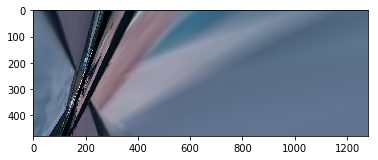

In [23]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

img1 = cv2.imread('img/restaurant1.jpg')
img2 = cv2.imread('img/restaurant2.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# detector = cv2.ORB_create()
detector = cv2.xfeatures2d.SIFT_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
matcher = cv2.DescriptorMatcher_create("BruteForce")
matches = matcher.knnMatch(desc1, desc2, 2)

ratio = 0.75
good_matches = [first for first,second in matches \
                    if first.distance < second.distance * ratio]
# 기준 좌표
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])
#위의 코드가 이해 안되면 출력해보기
# print(src_pts)
# print(kp1[m.queryIdx]) #객체
# print(kp1[m.queryIdx].pt) #좌표
    
# 좋은 매칭점의 trainIdx로 대상 영상의 좌표 구하기 ---④
# 대상 좌표
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches ])
# 원근 변환 행렬 구하기 ---⑤
mtrx, mask = cv2.findHomography(src_pts, dst_pts)
# 원본 영상 크기로 변환 영역 좌표 생성 ---⑥
h,w, = img1.shape[:2]
h2,w2, = img2.shape[:2]

# print(h,w)
pts = np.float32([ [[0,0]],[[0,h2-1]],[[w2-1,h2-1]],[[w2-1,0]] ])
# 원본 영상 좌표를 원근 변환  ---⑦
dst = cv2.perspectiveTransform(pts,mtrx)
# 변환 좌표 영역을 대상 영상에 그리기 ---⑧
# img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
# print(h2,w2)
# print(np.int32(dst))

# res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
#                     flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
def calcFinalImgSize(imgs, loc):
    global V_templ_ratio, H_templ_ratio
    y_offset = 0
    max_margin_top = 0; max_margin_bottom = 0 # maximum margins that will be needed above and bellow the first image in order to stitch all the images into one mat
    current_margin_top = 0; current_margin_bottom = 0

    h_init, w_init = imgs[0].shape[:2]
    w_final = w_init

    for i in range(0,len(loc)):
        h, w = imgs[i].shape[:2]
        h2, w2 = imgs[i+1].shape[:2]
        # we compute the max top/bottom margins that will be needed (relatively to the first input image) in order to stitch all the images
        current_margin_top += loc[i][1] # here, we assume that the template top-left corner Y-coordinate is 0 (relatively to its original image)
        current_margin_bottom += (h2 - loc[i][1]) - h
        if(current_margin_top > max_margin_top): max_margin_top = current_margin_top
        if(current_margin_bottom > max_margin_bottom): max_margin_bottom = current_margin_bottom
        # we compute the width needed for the final result
        x_templ = int(float(w)*H_templ_ratio) # x-coordinate of the template relatively to its original image
        w_final += (w2 - x_templ - loc[i][0]) # width needed to stitch all the images into one mat

    h_final = h_init + max_margin_top + max_margin_bottom
    return (max_margin_top, h_final, w_final)

def stitchImages(imgs, templates_loc):
    y_offset, h_final, w_final = calcFinalImgSize(imgs, templates_loc) # we calculate the "surface" needed to stitch all the images into one mat (and y_offset, the Y offset of the first image to be stitched) 
    result = np.zeros((h_final, w_final, 3), np.uint8)

    #initial stitch
    h_init, w_init = imgs[0].shape[:2]
    result[y_offset:y_offset+h_init, 0:w_init] = imgs[0]
    origin = (y_offset, 0) # top-left corner of the last stitched image (y,x)
    # stitching loop
    for j in range(0,len(templates_loc)):
        h, w = imgs[j].shape[:2]
        h2, w2 = imgs[j+1].shape[:2]
        # we compute the coordinates where to stitch imgs[j+1]
        y1 = origin[0] - templates_loc[j][1]
        y2 = origin[0] - templates_loc[j][1] + h2
        x_templ = int(float(w)*(1-H_templ_ratio)) # x-coordinate of the template relatively to its original image's right side
        x1 = origin[1] + x_templ - templates_loc[j][0]
        x2 = origin[1] + x_templ - templates_loc[j][0] + w2
        result[y1:y2, x1:x2] = imgs[j+1] # we copy the input image into the result mat
        origin = (y1,x1) # we update the origin point with the last stitched image

    return(result)
#---③ 짝지은 3개의 좌표로 변환 행렬 계산
# mtrx = cv2.getAffineTransform(pts1, pts2)
# mask
#---④ 어핀 변환 적용
# mtrx = cv2.getPerspectiveTransform(rect, dst)
#---④ 원근 변환 적용
warped = cv2.warpPerspective(img1, mtrx, (w + w2, h))
# imgs = [warped, img2]
# templates_loc = []
# result = stitchImages(imgs, templates_loc)

plt.imshow(warped)
plt.show()
# plt.imshow(img1)
# plt.show()
# plt.imshow(img2)
# plt.show()

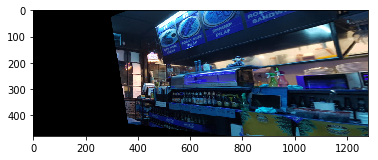

In [2]:
import cv2, numpy as np
import matplotlib.pyplot as plt

# 왼쪽 오른쪽 사진 읽기
imgL = cv2.imread('img/restaurant1.jpg') # train
imgR = cv2.imread('img/restaurant2.jpg') # query
hl, wl = imgL.shape[:2]
hr, wr = imgR.shape[:2]

grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

# SIFT 특징 검출기 생성 및 특징점 검출
descriptor = cv2.xfeatures2d.SIFT_create()
(kpsL, featuresL) = descriptor.detectAndCompute(imgL, None)
(kpsR, featuresR) = descriptor.detectAndCompute(imgR, None)
# BF 매칭기 생성 및 knn매칭
matcher = cv2.DescriptorMatcher_create("BruteForce")
matches = matcher.knnMatch(featuresR, featuresL, 2)

# 좋은 매칭점 선별
good_matches = []
for m in matches:
    if len(m) == 2 and m[0].distance < m[1].distance * 0.75:
        good_matches.append(( m[0].trainIdx, m[0].queryIdx))

# 좋은 매칭점이 4개 이상 원근 변환 행렬 구하기
if len(good_matches) > 4:
    ptsL = np.float32([kpsL[i].pt for (i, _) in good_matches])
    ptsR = np.float32([kpsR[i].pt for (_, i) in good_matches])
    mtrx, status = cv2.findHomography(ptsR, ptsL, cv2.RANSAC, 4.0)
    #원근 변환 행렬로 오른쪽 사진을 원근 변환, 결과 이미지 크기는 사진 2장 크기
    panorama = cv2.warpPerspective(imgR, mtrx, (wr + wl, hr))
    plt.imshow(panorama)
    plt.show()

    # 왼쪽 사진을 원근 변환한 왼쪽 영역에 합성
    panorama[0:hl, 0:wl] = imgL
    
else:
    panorama = imgL
    
# cv2.imshow("Image Left", imgL)
# cv2.imshow("Image Right", imgR)
# cv2.imshow("Panorama", panorama)
# cv2.waitKey(0)      
# cv2.destroyAllWindows()

https://opencvlib.weebly.com/cvfindhomography.html

### 카메라로 객체 매칭
    - 노트북있는 팀원에게 가서 같이 해보기

    (1) 인식할 물체를 들고 스페이스바를 누른다. 
    (2) 마우스로 해당물체를 roi로 지정해준다.
    (독특한 문양이나, 모양이 아닐경우 얼굴을 roi 지정해서 해보자)

In [53]:
import cv2, numpy as np

img1 = None
win_name = 'Camera Matching'
MIN_MATCH = 10
# ORB 검출기 생성  ---①
detector = cv2.ORB_create(1000)
# Flann 추출기 생성 ---②
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6,
                   key_size = 12,
                   multi_probe_level = 1)
search_params=dict(checks=32)
matcher = cv2.FlannBasedMatcher(index_params, search_params)
# 카메라 캡쳐 연결 및 프레임 크기 축소 ---③
cap = cv2.VideoCapture(0)              
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

while cap.isOpened():       
    ret, frame = cap.read() 
    if img1 is None:  # 등록된 이미지 없음, 카메라 바이패스
        res = frame
    else:             # 등록된 이미지 있는 경우, 매칭 시작
        img2 = frame
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        # 키포인트와 디스크립터 추출
        kp1, desc1 = detector.detectAndCompute(gray1, None)
        kp2, desc2 = detector.detectAndCompute(gray2, None)
        # k=2로 knnMatch
        matches = matcher.knnMatch(desc1, desc2, 2)
        # 이웃 거리의 75%로 좋은 매칭점 추출---②
        ratio = 0.75
        good_matches = [m[0] for m in matches \
                if len(m) == 2 and m[0].distance < m[1].distance * ratio]
        print('good matches:%d/%d' %(len(good_matches),len(matches)))
        # 모든 매칭점 그리지 못하게 마스크를 0으로 채움
        matchesMask = np.zeros(len(good_matches)).tolist()
        # 좋은 매칭점 최소 갯수 이상 인 경우
        if len(good_matches) > MIN_MATCH: 
            # 좋은 매칭점으로 원본과 대상 영상의 좌표 구하기 ---③
            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ])
            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ])
            # 원근 변환 행렬 구하기 ---⑤
            mtrx, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            accuracy=float(mask.sum()) / mask.size
            print("accuracy: %d/%d(%.2f%%)"% (mask.sum(), mask.size, accuracy))
            if mask.sum() > MIN_MATCH:  # 정상치 매칭점 최소 갯수 이상 인 경우
                # 이상점 매칭점만 그리게 마스크 설정
                matchesMask = mask.ravel().tolist()
                # 원본 영상 좌표로 원근 변환 후 영역 표시  ---⑦
                h,w, = img1.shape[:2]
                pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])
                dst = cv2.perspectiveTransform(pts,mtrx)
                img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
        # 마스크로 매칭점 그리기 ---⑨
        res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                            matchesMask=matchesMask,
                            flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    # 결과 출력
    cv2.imshow(win_name, res)
    key = cv2.waitKey(1)
    if key == 27:    # Esc, 종료
            break          
    elif key == ord(' '): # 스페이스바를 누르면 ROI로 img1 설정
        x,y,w,h = cv2.selectROI(win_name, frame, False)
        if w and h:
            img1 = frame[y:y+h, x:x+w]
else:
    print("can't open camera.")
cap.release()                          
cv2.destroyAllWindows()

good matches:25/78
accuracy: 20/25(0.80%)
good matches:31/78
accuracy: 24/31(0.77%)
good matches:29/78
accuracy: 24/29(0.83%)
good matches:30/78
accuracy: 24/30(0.80%)
good matches:30/78
accuracy: 25/30(0.83%)
good matches:31/78
accuracy: 26/31(0.84%)
good matches:27/78
accuracy: 23/27(0.85%)
good matches:36/78
accuracy: 33/36(0.92%)
good matches:35/78
accuracy: 31/35(0.89%)
good matches:35/78
accuracy: 31/35(0.89%)
good matches:29/78
accuracy: 22/29(0.76%)
good matches:28/78
accuracy: 25/28(0.89%)
good matches:33/78
accuracy: 26/33(0.79%)
good matches:27/78
accuracy: 26/27(0.96%)
good matches:30/78
accuracy: 25/30(0.83%)
good matches:32/78
accuracy: 23/32(0.72%)
good matches:21/78
accuracy: 18/21(0.86%)
good matches:25/78
accuracy: 22/25(0.88%)
good matches:26/78
accuracy: 22/26(0.85%)
good matches:19/78
accuracy: 17/19(0.89%)
good matches:23/78
accuracy: 19/23(0.83%)
good matches:27/78
accuracy: 26/27(0.96%)
good matches:20/78
accuracy: 17/20(0.85%)
good matches:25/78
accuracy: 20/25

accuracy: 13/14(0.93%)
good matches:16/78
accuracy: 14/16(0.88%)
good matches:14/78
accuracy: 10/14(0.71%)
good matches:13/78
accuracy: 10/13(0.77%)
good matches:10/78
good matches:11/78
accuracy: 9/11(0.82%)
good matches:13/78
accuracy: 12/13(0.92%)
good matches:6/78
good matches:24/78
accuracy: 17/24(0.71%)
good matches:18/78
accuracy: 15/18(0.83%)
good matches:17/78
accuracy: 12/17(0.71%)
good matches:17/78
accuracy: 12/17(0.71%)
good matches:20/78
accuracy: 15/20(0.75%)
good matches:19/78
accuracy: 15/19(0.79%)
good matches:9/78
good matches:14/78
accuracy: 11/14(0.79%)
good matches:22/78
accuracy: 16/22(0.73%)
good matches:14/78
accuracy: 10/14(0.71%)
good matches:22/78
accuracy: 15/22(0.68%)
good matches:17/78
accuracy: 12/17(0.71%)
good matches:19/78
accuracy: 16/19(0.84%)
good matches:17/78
accuracy: 14/17(0.82%)
good matches:22/78
accuracy: 17/22(0.77%)
good matches:22/78
accuracy: 18/22(0.82%)
good matches:20/78
accuracy: 14/20(0.70%)
good matches:17/78
accuracy: 14/17(0.82%)

## 객체 추적

### 동영상배경제거
: 배경이 있는 영상에서 객체가 있는 영상을 뺀다.
* cv2.bgsegm.createBackgroundSubtractorMOG()
: open cv에서 배경을 제거하는 다양한 알고리즘을 하나의 인터페이스로 통일한 배경객체 함수

### BackgroundSubtractorMOG 배경제거

In [54]:
import numpy as np, cv2

cap = cv2.VideoCapture('img/walking.avi')
fps = cap.get(cv2.CAP_PROP_FPS) # 프레임 수 구하기
delay = int(1000/fps)
# 배경 제거 객체 생성 --- ①
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # 배경 제거 마스크 계산 --- ②
    fgmask = fgbg.apply(frame)
    cv2.imshow('frame',frame)
    cv2.imshow('bgsub',fgmask)
    if cv2.waitKey(1) & 0xff == 27:
        break
cap.release()
cv2.destroyAllWindows()

### BackgroundSubtractorMOG2 배경제거
: 가우시안 분포값을 사용, 그림자 검출 \가능(느려짐)

In [57]:
import numpy as np, cv2

cap = cv2.VideoCapture('img/walking.avi')
fps = cap.get(cv2.CAP_PROP_FPS) # 프레임 수 구하기
delay = int(1000/fps)
# 배경 제거 객체 생성 --- ①
fgbg = cv2.createBackgroundSubtractorMOG2()
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # 배경 제거 마스크 계산 --- ②
    fgmask = fgbg.apply(frame)
    cv2.imshow('frame',frame)
    cv2.imshow('bgsub',fgmask)
    if cv2.waitKey(delay) & 0xff == 27:
        break
cap.release()
cv2.destroyAllWindows()

### BackgroundSubtractorMOG2 배경제거_2 ( 팀원 노트북으로 같이 확인해보기)

In [63]:
import cv2

cap = cv2.VideoCapture(0)               # 0번 카메라 장치 연결 ---①
cap.set(3, 480)
fgbg = cv2.createBackgroundSubtractorMOG2()

while True:
    ret, frame = cap.read()           # 다음 프레임 읽기
    fgmask = fgbg.apply(frame)
    cv2.imshow('camera', fgmask)   # 다음 프레임 이미지 표시
    if cv2.waitKey(1) != -1:    # 1ms 동안 키 입력 대기 ---②
        break                   # 아무 키라도 입력이 있으면 중지

cap.release()                           # 자원 반납
cv2.destroyAllWindows()

### 옵티컬 플로
: 이전 장면과 다음 장면 사이의 픽셀이 이동한 방향과 거리에 대한 분포

* coners = cv2.goodFeaturesToTrack(img, maxCorners, qualitLevel, minDistance)
    - img : 입력 영상
    - maxCorners : 얻고 싶은 코너 개수 (강한 순)
    - qualityLevel : 코너로 판단할 스레시 홀드 값
    - minDistance : 코너간 최소거리
    - cornes : 코너 검출 좌표 결과 (실수 값으로 정수로 변형 필요)
####    
* nextPt, status, err = cv2.calcOpticalFlowPyrLK(prevImg, nextImg, prevPt, nextPt \
  [criteria=termcriteria])
    - prevImg : 이전 프레임 영상 
    - nextImg : 다름 프레임 영상
    - prevPt : 이전 프레임의 코너 특징점, cv2.goodFeaturesToTrack()으로 검출
    - nextPt : 다음 프레임 에서 이동한 코너 특징점
    - criteria=(COUNT + EPS, 30, 0.01) : 반복 탐색 중지 요건
        - cv2.TERM_CRITERIA_EPS : 정확도가 epsilon보다 작으면
        - cv2.TERM_CRITERIA_COUNT : max_iter(최대반복횟수)를 다 채우면
    - status : 결과 상태 벡터 
    - err : 결과 에러 벡터 

### calcOpticalFlowPyrLK를 이용한 추적 
    - Esc:종료
    - Backspace:추적 이력 지우기

In [29]:
import numpy as np, cv2

cap = cv2.VideoCapture('img/walking.avi')
fps = cap.get(cv2.CAP_PROP_FPS) # 프레임 수 구하기
delay = int(1000/fps)
# 추적 경로를 그리기 위한 랜덤 색상
color = np.random.randint(0,255,(200,3))
lines = None  #추적 선을 그릴 이미지 저장 변수
prevImg = None  # 이전 프레임 저장 변수
# calcOpticalFlowPyrLK 중지 요건 설정
# 1. cv2.TERM_CRITERIA_EPS 정확도가 epsilon보다 작으면
#  2. cv2.TERM_CRITERIA_COUNT 최대반복횟수를 채우면
termcriteria =  (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)


while cap.isOpened():
    ret,frame = cap.read()
    if not ret:
        break
    img_draw = frame.copy()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # 최초 프레임 경우
    if prevImg is None:
        prevImg = gray
        # 추적선 그릴 이미지를 프레임 크기에 맞게 생성
        lines = np.zeros_like(frame)
        # 추적 시작을 위한 코너 검출  ---①
        prevPt = cv2.goodFeaturesToTrack(prevImg, 200, 0.01, 10)
    else:
        nextImg = gray
        # 옵티컬 플로우로 다음 프레임의 코너점  찾기 ---②
        nextPt, status, err = cv2.calcOpticalFlowPyrLK(prevImg, nextImg, \
                                        prevPt, None, criteria=termcriteria) # criteria : 반복탐색중지요건
        # 대응점이 있는 코너, 움직인 코너 선별 ---③
        prevMv = prevPt[status==1]
        nextMv = nextPt[status==1]
        for i,(p, n) in enumerate(zip(prevMv, nextMv)):
            px,py = p.ravel() #배열을 펴준다.
            nx,ny = n.ravel()
            # 이전 코너와 새로운 코너에 선그리기 ---④
            cv2.line(lines, (px, py), (nx,ny), color[i].tolist(), 2)
            # 새로운 코너에 점 그리기
            cv2.circle(img_draw, (nx,ny), 2, color[i].tolist(), -1)
        # 누적된 추적 선을 출력 이미지에 합성 ---⑤
        img_draw = cv2.add(img_draw, lines)
        # 다음 프레임을 위한 프레임과 코너점 이월
        prevImg = nextImg
        prevPt = nextMv.reshape(-1,1,2)

    cv2.imshow('OpticalFlow-LK', img_draw)
    key = cv2.waitKey(delay)
    if key == 27 : # Esc:종료
        break
    elif key == 8: # Backspace:추적 이력 지우기
        prevImg = None
cv2.destroyAllWindows()
cap.release()

### CamShift 추적
    - 코드 설명 생략
    - 아래의 TrackAPI와 같이 팀원 노트북으로 같이 확인해보기

In [28]:
import numpy as np, cv2

roi_hist = None     # 추적 객체 히스토그램 저장 변수
win_name = 'Camshift Tracking'
termination =  (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
while cap.isOpened():
    ret, frame = cap.read()    
    img_draw = frame.copy()
    
    if roi_hist is not None:  # 추적 대상 객체 히스토그램 등록 됨
        # 전체 영상 hsv 컬로 변환 ---①
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        # 전체 영상 히스토그램과 roi 히스트그램 역투영 ---②
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0,180], 1)
        # 역 투영 결과와 초기 추적 위치로 평균 이동 추적 ---③
        ret, (x,y,w,h) = cv2.CamShift(dst, (x,y,w,h), termination)
        # 새로운 위치에 사각형 표시 ---④
        cv2.rectangle(img_draw, (x,y), (x+w, y+h), (0,255,0), 2)
        # 컬러 영상과 역투영 영상을 통합해서 출력
        result = np.hstack((img_draw, cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)))
    else:  # 추적 대상 객체 히스토그램 등록 안됨
        cv2.putText(img_draw, "Hit the Space to set target to track", \
                (10,30),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)
        result = img_draw

    cv2.imshow(win_name, result)
    key = cv2.waitKey(1) & 0xff
    if  key == 27: # Esc
        break
    elif key == ord(' '): # 스페이스-바, ROI 설정
        x,y,w,h = cv2.selectROI(win_name, frame, False)
        if w and h :    # ROI가 제대로 설정됨
            # 초기 추적 대상 위치로 roi 설정 --- ⑤
            roi = frame[y:y+h, x:x+w]
            # roi를 HSV 컬러로 변경 ---⑥
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
            mask = None
            # roi에 대한 히스토그램 계산 ---⑦
            roi_hist = cv2.calcHist([roi], [0], mask, [180], [0,180])
            cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)
        else:                       # ROI 설정 안됨
            roi_hist = None
else:
    print('no camera!')
cap.release()
cv2.destroyAllWindows()

no camera!


### Tracking API 
    - 17번째 주석 풀고, 16번째 주석처리하여 결과 확인
    - 조원 노트북으로 확인하기
    - 0 ~ 7 숫자 ( 5제외, OPEN CV 3.4버전에서 버그) 변경해보기

In [27]:
import cv2

# 트랙커 객체 생성자 함수 리스트 ---①
trackers = [cv2.TrackerBoosting_create,
            cv2.TrackerMIL_create,
            cv2.TrackerKCF_create,
            cv2.TrackerTLD_create,
            cv2.TrackerMedianFlow_create,
            cv2.TrackerGOTURN_create, #버그로 오류 발생
            cv2.TrackerCSRT_create,
            cv2.TrackerMOSSE_create]
trackerIdx = 0  # 트랙커 생성자 함수 선택 인덱스
tracker = None
isFirst = True

video_src = 0 # 비디오 파일과 카메라 선택 ---②
video_src = "img/highway.mp4"
cap = cv2.VideoCapture(video_src)
fps = cap.get(cv2.CAP_PROP_FPS) # 프레임 수 구하기
delay = int(1000/fps)
win_name = 'Tracking APIs'
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print('Cannot read video file')
        break
    img_draw = frame.copy()
    if tracker is None: # 트랙커 생성 안된 경우
        cv2.putText(img_draw, "Press the Space to set ROI!!", \
            (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2,cv2.LINE_AA)
    else:
        ok, bbox = tracker.update(frame)   # 새로운 프레임에서 추적 위치 찾기 ---③
        (x,y,w,h) = bbox
        if ok: # 추적 성공
            cv2.rectangle(img_draw, (int(x), int(y)), (int(x + w), int(y + h)), \
                          (0,255,0), 2, 1)
        else : # 추적 실패
            cv2.putText(img_draw, "Tracking fail.", (100,80), \
                        cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2,cv2.LINE_AA)
    trackerName = tracker.__class__.__name__
    cv2.putText(img_draw, str(trackerIdx) + ":"+trackerName , (100,20), \
                 cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,255,0),2,cv2.LINE_AA)

    cv2.imshow(win_name, img_draw)
    key = cv2.waitKey(delay) & 0xff
    # 스페이스 바 또는 비디오 파일 최초 실행 ---④
    if key == ord(' ') or (video_src != 0 and isFirst): 
        isFirst = False
        roi = cv2.selectROI(win_name, frame, False)  # 초기 객체 위치 설정
        if roi[2] and roi[3]:         # 위치 설정 값 있는 경우
            tracker = trackers[trackerIdx]()    #트랙커 객체 생성 ---⑤
            isInit = tracker.init(frame, roi)
    elif key in range(48, 56): # 0~7 숫자 입력   ---⑥
        trackerIdx = key-48     # 선택한 숫자로 트랙커 인덱스 수정
        if bbox is not None:
            tracker = trackers[trackerIdx]() # 선택한 숫자의 트랙커 객체 생성 ---⑦
            isInit = tracker.init(frame, bbox) # 이전 추적 위치로 추적 위치 초기화
    elif key == 27 : 
        break
else:
    print( "Could not open video")
cap.release()
cv2.destroyAllWindows()

### 책표지 검색기
    - 코드 설명 생략, 조원 컴퓨터로 확인해보기
    - 책을 사각형안에 넣고 Space Bar

In [1]:
import cv2 , glob, numpy as np

# 검색 설정 변수 ---①
ratio = 0.7
MIN_MATCH = 10
# ORB 특징 검출기 생성 ---②
detector = cv2.ORB_create()
# Flann 매칭기 객체 생성 ---③
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6,
                   key_size = 12,
                   multi_probe_level = 1)
search_params=dict(checks=32)
matcher = cv2.FlannBasedMatcher(index_params, search_params)

# 책 표지 검색 함수 ---④
def serch(img):
    gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp1, desc1 = detector.detectAndCompute(gray1, None)
    
    results = {}
    # 책 커버 보관 디렉토리 경로 ---⑤
    cover_paths = glob.glob('img/books/*.*')
    for cover_path in cover_paths:
        cover = cv2.imread(cover_path)
        cv2.imshow('Searching...', cover) # 검색 중인 책 표지 표시 ---⑥
        cv2.waitKey(5)
        gray2 = cv2.cvtColor(cover, cv2.COLOR_BGR2GRAY)
        kp2, desc2 = detector.detectAndCompute(gray2, None) # 특징점 검출 ---⑦
        matches = matcher.knnMatch(desc1, desc2, 2) # 특징점 매칭 ---⑧
        # 좋은 매칭 선별 ---⑨
        good_matches = [m[0] for m in matches \
                    if len(m) == 2 and m[0].distance < m[1].distance * ratio]
        if len(good_matches) > MIN_MATCH: 
            # 좋은 매칭점으로 원본과 대상 영상의 좌표 구하기 ---⑩
            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ])
            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ])
            # 원근 변환 행렬 구하기 ---⑪
            mtrx, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            # 원근 변환 결과에서 정상치 비율 계산 ---⑫
            accuracy=float(mask.sum()) / mask.size
            results[cover_path] = accuracy
    cv2.destroyWindow('Searching...')
    if len(results) > 0:
        results = sorted([(v,k) for (k,v) in results.items() \
                    if v > 0], reverse=True)
    return results

cap = cv2.VideoCapture(0)
qImg = None
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print('No Frame!')
        break
    h, w = frame.shape[:2]
    # 화면에 책을 인식할 영역 표시 ---⑬
    left = w // 3
    right = (w // 3) * 2
    top = (h // 2) - (h // 3)
    bottom = (h // 2) + (h // 3)
    cv2.rectangle(frame, (left,top), (right,bottom), (255,255,255), 3)
    
    # 거울 처럼 보기 좋게 화면 뒤집어 보이기
    flip = cv2.flip(frame,1)
    cv2.imshow('Book Searcher', flip)
    key = cv2.waitKey(10)
    if key == ord(' '): # 스페이스-바를 눌러서 사진 찍기
        qImg = frame[top:bottom , left:right]
        cv2.imshow('query', qImg)
        break
    elif key == 27 : #Esc
        break
else:
    print('No Camera!!')
cap.release()

if qImg is not None:
    gray = cv2.cvtColor(qImg, cv2.COLOR_BGR2GRAY)
    results = serch(qImg)
    if len(results) == 0 :
        print("No matched book cover found.")
    else:
        for( i, (accuracy, cover_path)) in enumerate(results):
            print(i, cover_path, accuracy)
            if i==0:
                cover = cv2.imread(cover_path)
                cv2.putText(cover, ("Accuracy:%.2f%%"%(accuracy*100)), (10,100), \
                             cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
    cv2.imshow('Result', cover)
cv2.waitKey()
cv2.destroyAllWindows()

0 img/books\opencv2.jpg 0.9552238805970149
